In [2]:
import sys
sys.path.append('/home/ABTLUS/victor.secco/data_processing') 
import os
import numpy as np
import matplotlib.pyplot as plt
import pyFAI
from mypackages.edp_processing import ImageAnalysis, load_empad_data, highest_distance_to_border, peak_calibration
import hyperspy.api as hs
import math


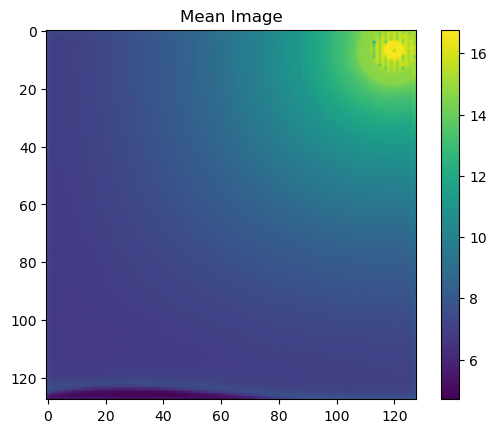

1.93e+07


In [114]:
directory = '/home/ABTLUS/victor.secco/data_processing/TEM_data/07Feb24/glass/'
au_directories = [d for d in os.listdir(directory) if d.startswith('Au_230mm_10eA_5ms_200im_corner') and os.path.isdir(os.path.join(directory, d))]

data = []

for dir_name in au_directories:
    dir_path = os.path.join(directory, dir_name)
    # Assuming you want to process all files in the directory, adjust if it's just one specific file
    for file_name in os.listdir(dir_path):
        if file_name.endswith('.raw'):
            file_path = os.path.join(dir_path, file_name)

            data.append(load_empad_data(file_path, 200))

data = np.array(data).reshape(600, 128, 128)

if 'data' in locals():  # Checks if 'data' variable exists
    mean_image = data.mean(axis = 0)
    mean_image_log = np.log(mean_image)
    mean_image_log = np.nan_to_num(mean_image_log, nan=0.0, posinf=None, neginf=None)
    plt.imshow(mean_image_log)
    plt.colorbar()
    plt.title("Mean Image")
    plt.show()

print(format(data[0].max(), ".2e"))
analysis = ImageAnalysis()

In [64]:
directory = '/home/ABTLUS/victor.secco/data_processing/TEM_data/07Feb24/Corning_Gain/Au'
names = [x for x in os.listdir(directory) if x.endswith('.ser')] 

file_path = os.path.join(directory, names[1])
signal = hs.load(file_path, signal_type='diffraction')
data = np.array(signal)

In [67]:
data.shape

(20, 4096, 4096)

The center found was (120, 6)


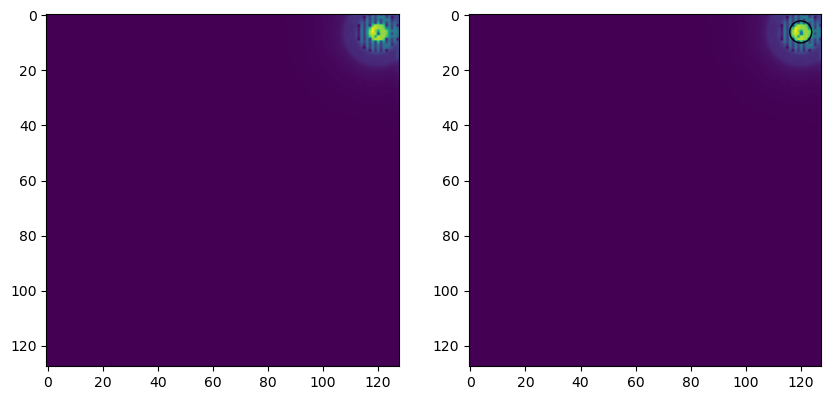

In [113]:
#@title 1.3.1 Encontrar o centro (HOUGH)
from matplotlib.patches import Circle

mean_image_thresholded = np.where(mean_image < 9000000, mean_image, 0)

center_x, center_y, r  = analysis.find_center(data[0], 1, 5000, 100, 255, 10)

azimuth_ranges_set1 = [(89, 91), (-91, -89)]
azimuth_ranges_set2 = [(-50, -48), (129, 131)]

circle1 = Circle((center_x, center_y), r,  fill = False )

#center_x, center_y = 2266, 1983
print('The center found was 'f'{center_x, center_y}')

f, ax = plt.subplots(1,2, figsize = (10,20))
ax[1].imshow(data[0])
ax[1].scatter(center_x, center_y, s=1)
ax[1].add_patch(circle1)
ax[0].imshow(data[0])
plt.show()

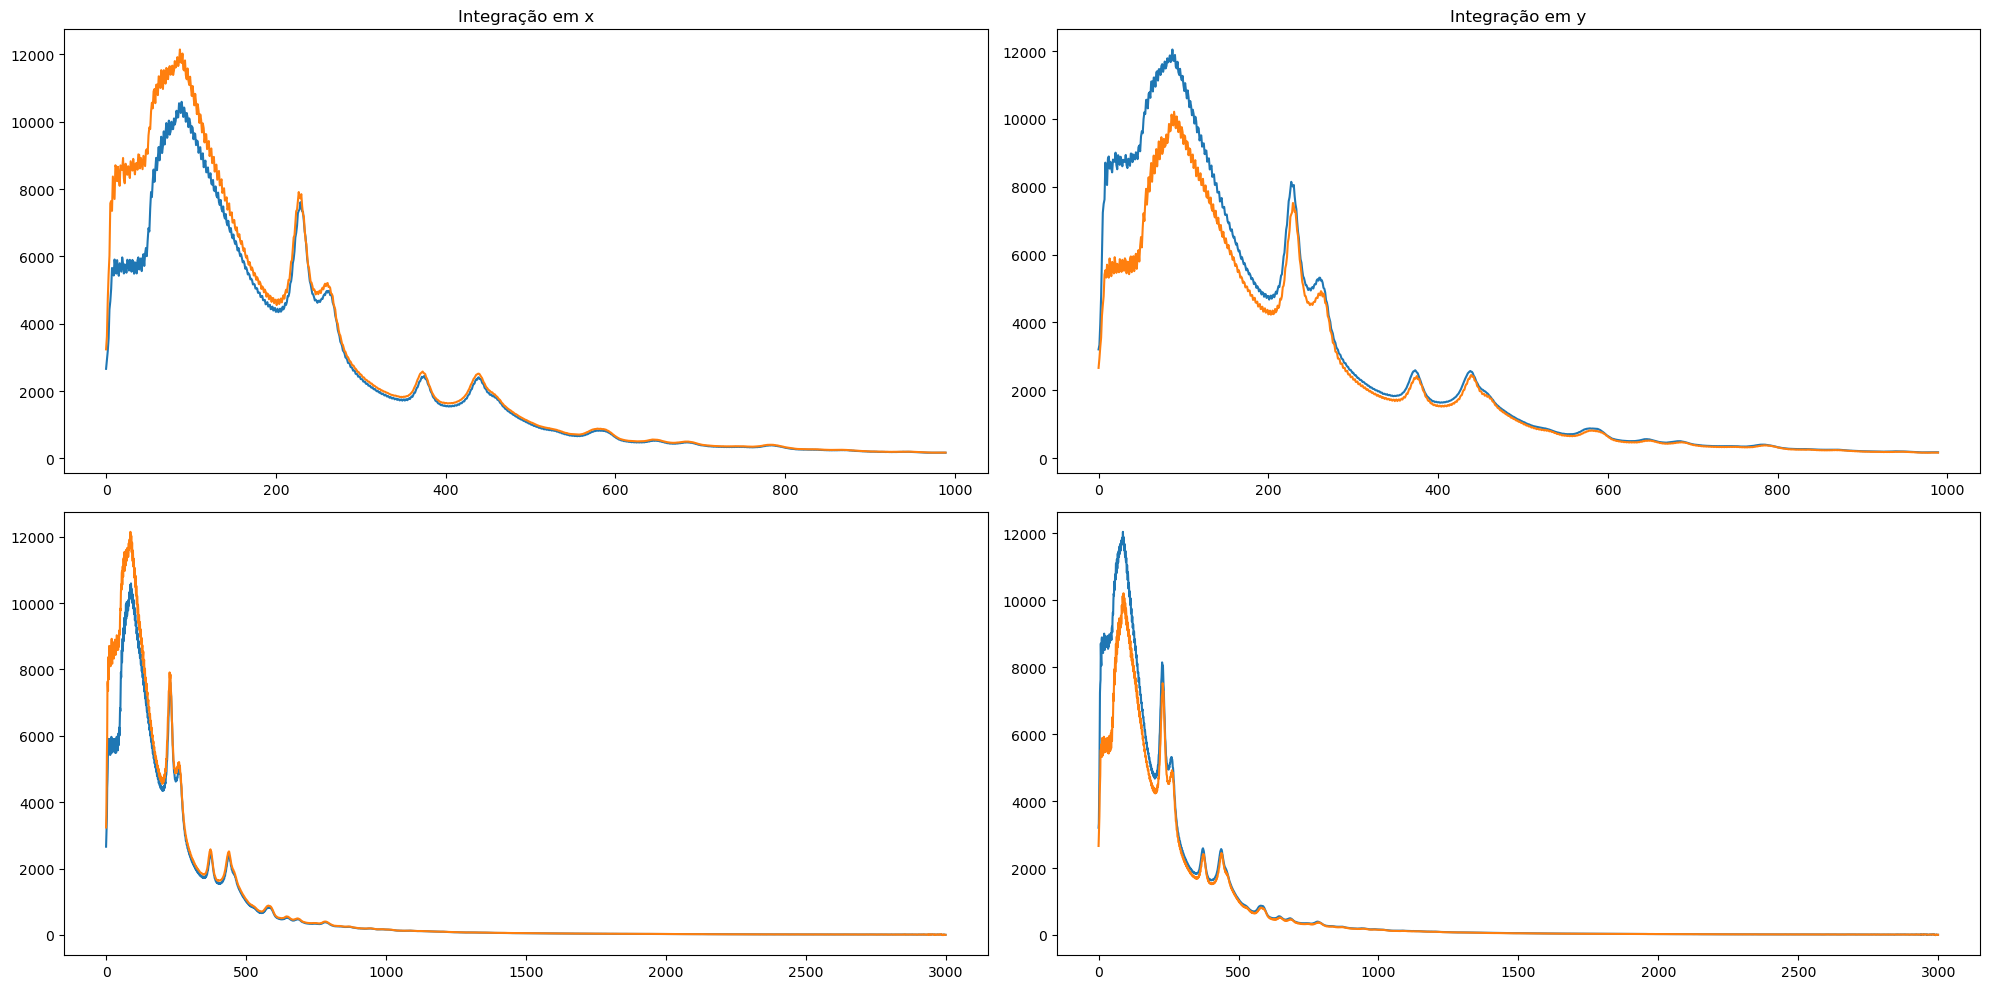

In [78]:
#@title 1.4. Testes com o centro obtido pela transformada de Hough

binning = 3000


#center_x, center_y = 2326, 1962

azimuth_ranges_set1 = [(89, 91), (-91, -89)]
azimuth_ranges_set2 = [(-50, -48), (129, 131)]
#center_x, center_y = analysis.optimize_center(masked_stacked, center_x, center_y, azimuth_ranges_set1 + azimuth_ranges_set2, max_iterations = 20)

center_x, center_y

ai = pyFAI.azimuthalIntegrator.AzimuthalIntegrator(dist=0.1, pixel1=1e-4, pixel2=1e-4)
ai.setFit2D(1024, center_x, center_y)
stacked1= data[0]

res1 = ai.integrate1d(stacked1, binning, unit='2th_deg', azimuth_range=(80, 100), method = "ocl_lut_integr")
res2 = ai.integrate1d(stacked1, binning, unit='2th_deg', azimuth_range=(-100, -80), method = "ocl_lut_integr")
res3 = ai.integrate1d(stacked1, binning, unit='2th_deg', azimuth_range=(-60, -40), method = "ocl_lut_integr")
res4 = ai.integrate1d(stacked1, binning, unit='2th_deg', azimuth_range=(120, 140), method = "ocl_lut_integr")

res1, res2 = np.array(res1), np.array(res2)
res3, res4 = np.array(res3), np.array(res4)

fig,ax= plt.subplots(2,2,figsize=(20, 10))

ax[0, 0].set_title('Integração em x')
ax[0, 0].plot(res1[1][0:int(0.33*binning)])
ax[0, 0].plot(res2[1][0:int(0.33*binning)])
#ax[0, 0].text(200, 0.5 * res3[1][100:600].max(), f'Melhor erro: {best_error:.2f} com centro 'f'{best_centro}', fontsize=12, color='red')
#ax[0, 0].text(200, 0.4 * res3[1][100:600].max(), f'EQM: {(erro_x + erro_y):.2f} com centro 'f'{center_x, center_y}', fontsize=12, color='red')

ax[0, 1].set_title('Integração em y')
#ax[0, 1].set_xlim(0, 500)
ax[0, 1].plot(res3[1][0:int(0.33*binning)])
ax[0, 1].plot(res4[1][0:int(0.33*binning)])

ax[1, 0].plot(res1[1])
ax[1, 0].plot(res2[1])

ax[1, 1].plot(res3[1])
ax[1, 1].plot(res4[1])

plt.tight_layout()
plt.show()


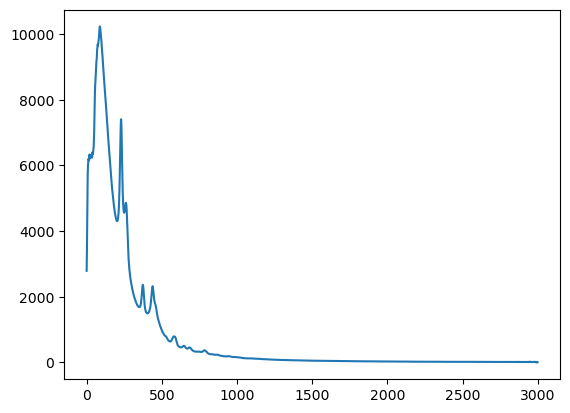

In [81]:

#center_x, center_y = analysis.optimize_center(masked_stacked, center_x, center_y, azimuth_ranges_set1 + azimuth_ranges_set2, max_iterations = 20)

center_x, center_y

ai = pyFAI.azimuthalIntegrator.AzimuthalIntegrator(dist=0.1, pixel1=1e-4, pixel2=1e-4)
ai.setFit2D(1024, center_x, center_y)
stacked1= data[0]

res, intensity = ai.integrate1d(stacked1, binning, unit='2th_deg', azimuth_range=(-180, 180), method = "ocl_lut_integr")
plt.plot(intensity)



In [3]:
import pandas as pd

cif = '/home/ABTLUS/victor.secco/data_processing/Banco de Dados Cristalográficos/Au_52700.txt'


peaks = [229, 261, 374, 439]

calibration = peak_calibration(peaks)

The calculated calibration factor ds: 0.01168543627665498


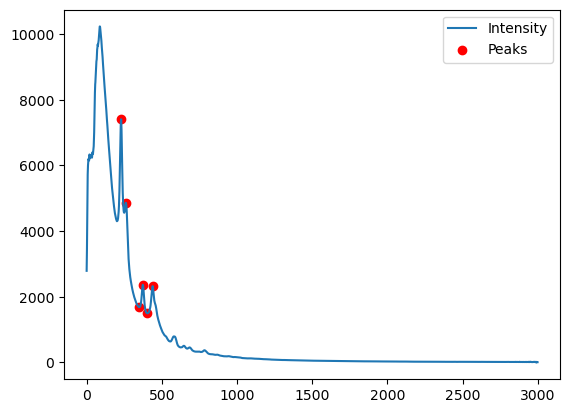

In [96]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(intensity,)

# Plot original intensity data
plt.plot(intensity, label='Intensity')

# Plot the peaks on top of the original data
plt.scatter(peaks[10:16], intensity[peaks[10:16]], color='red', label='Peaks')  # Corrected to access intensity values correctly

plt.legend()
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

#blur = cv2.normalize(src=images[0], dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

x = np.arange(images[0].shape[1])
y = np.arange(images[0].shape[0])
x, y = np.meshgrid(x, y)

# Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
ax.plot_surface(x, y, np.sqrt(abs(images[0])), cmap='viridis', edgecolor='none')

ax.set_title("3D Plot of Image Array")
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Intensity")

ax.view_init(elev=50, azim=0) 
plt.show()

In [ ]:
from scipy.optimize import curve_fit



#def exponential_func(x, a, b, c):
#    return a * np.exp(b * x) + c

# Assuming x_data and y_data are defined
#params, covariance = curve_fit(exponential_func, range(len(intensity)), intensity)

degree = 7 
coefficients = np.polyfit(range(len(intensity)), intensity, degree)
polynomial = np.poly1d(coefficients)
y_fit = polynomial(range(len(intensity)))

# Plot the original data points
plt.scatter(range(len(intensity)), intensity, label='Original Data')

# Plot the fitted polynomial curve
plt.plot(range(len(intensity)), y_fit, color='red', label=f'Fitted Polynomial Degree {degree}')

plt.legend()
plt.show()